# Team Name: Resume Classifier
Team: Allen Snyder, Kevin Schroeder, Si Liang

Created on: 10/30/2025

# Preprocessing steps 30pts

Provide all essential steps that you deem necessary for your application

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

## Load Resume Data

In [2]:
# from google.colab import files

import re
import gc
import joblib
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

from scipy.stats import loguniform


In [ ]:
# Load the CSV file
df = pd.read_csv('../data/Resume.csv')

df.head()

## Raw Text of Resume #1 and #2

In [4]:
display(df['Resume_str'][0][:300])

'         HR ADMINISTRATOR/MARKETING ASSOCIATE\n\nHR ADMINISTRATOR       Summary     Dedicated Customer Service Manager with 15+ years of experience in Hospitality and Customer Service Management.   Respected builder and leader of customer-focused teams; strives to instill a shared, enthusiastic commit'

In [5]:
display(df['Resume_str'][1][:300])

'         HR SPECIALIST, US HR OPERATIONS       Summary     Versatile  media professional with background in Communications, Marketing, Human Resources and Technology.\xa0        Experience     09/2015   to   Current     HR Specialist, US HR Operations    Company Name   －   City  ,   State       Managed'

## Create Corpus

In [6]:
corpus = df['Resume_str'].tolist()

## Normalize Corpus

In [7]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = list(stopwords.words('english'))

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    wpt = nltk.WordPunctTokenizer()
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)
norm_corpus = normalize_corpus(corpus)
len(norm_corpus)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kevinschroeder/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


2484

### Preprocess corpus and print an example of a preprocess sentence

In [8]:
print(norm_corpus[0][:300])

hr administratormarketing associate hr administrator summary dedicated customer service manager 15 years experience hospitality customer service management respected builder leader customerfocused teams strives instill shared enthusiastic commitment customer service highlights focused customer satis


In [9]:
print(norm_corpus[1][:300])

hr specialist us hr operations summary versatile media professional background communications marketing human resources technology experience 092015 current hr specialist us hr operations company name city state managed communication regarding launch operations group policy changes system outages de


# Feature extraction (30pts)

Implement any existing feature extraction tools and methods (term frequency, word embeddings etc)

In [10]:
X = norm_corpus
y = df['Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Set up pipeline for Logistic Regression,
# MultinomialNB, and SVC models
# Each with a TF-IDF Vectorizer
pipelines = {
    'LogisticRegression': Pipeline([
        ('tfidf', TfidfVectorizer(stop_words=stop_words, max_features=10000)),
        ('classifier', LogisticRegression(class_weight='balanced', max_iter=2000))
    ]),
    'MultinomialNB': Pipeline([
        ('tfidf', TfidfVectorizer(stop_words=stop_words, max_features=10000)),
        ('classifier', MultinomialNB())
    ]),
    'SVC': Pipeline([
        ('tfidf', TfidfVectorizer(stop_words=stop_words, max_features=10000)),
        ('classifier', SVC(class_weight='balanced', max_iter=2000, probability=True))
    ])
}

## Define parameter grids for RandomizedSearchCV
## NOTE: This is the full list of parameters that we inintially considered
# full_param_grids = {
#     'LogisticRegression': {
#         # TF-IDF parameters
#         'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
#         'tfidf__min_df': [3, 5, 10],
#         'tfidf__max_df': [0.7, 0.8, 0.9],
#         'tfidf__max_features': [None, 5000, 10000],

#         # LR parameters
#         'classifier__C': [0.01, 0.1, 1, 10, 100],
#         'classifier__penalty': ['l2'],
#         'classifier__solver': ['lbfgs', 'saga']
#     },
#     'MultinomialNB': {
#         # TF-IDF parameters
#         'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
#         'tfidf__min_df': [3, 5, 10],
#         'tfidf__max_df': [0.7, 0.8, 0.9],
#         'tfidf__max_features': [None, 5000, 10000],

#         # Naive Bayes parameters
#         'classifier__alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0],
#         'classifier__fit_prior': [True, False]
#     },
#     'SVC': {
#         # TF-IDF parameters
#         'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
#         'tfidf__min_df': [3, 5, 10],
#         'tfidf__max_df': [0.7, 0.8, 0.9],
#         'tfidf__max_features': [None, 5000, 10000],

#         # SVC parameters
#        'classifier__C': [0.01, 0.1, 1, 10, 100],
#        'classifier__kernel': ['linear', 'rbf'],
#        'classifier__gamma': ['scale', 'auto']
#     }
# }

## Define parameter grids for RandomizedSearchCV
## NOTE: this is a reduced set of parameters for quicker tuning
param_grids = {
    'LogisticRegression': {
        # TF-IDF parameters
        'tfidf__ngram_range': [(1, 3)],
        'tfidf__min_df': [5],
        'tfidf__max_df': [0.9],
        'tfidf__max_features': [10000],

        # LR parameters
        'classifier__C': [100],
        'classifier__penalty': ['l2'],
        'classifier__solver': ['saga']
    },
    'MultinomialNB': {
        # TF-IDF parameters
        'tfidf__ngram_range': [(1, 2)],
        'tfidf__min_df': [5],
        'tfidf__max_df': [0.7],
        'tfidf__max_features': [10000],

        # Naive Bayes parameters
        'classifier__alpha': [0.01],
        'classifier__fit_prior': [False]
    },
    'SVC': {
        # TF-IDF parameters
        'tfidf__ngram_range': [(1, 3)],
        'tfidf__min_df': [10],
        'tfidf__max_df': [0.8],
        'tfidf__max_features': [None],

        # SVC parameters
        'classifier__C': [1],
        'classifier__kernel': ['linear'],
        'classifier__gamma': ['auto']
    }
}


# Train and tune all models
grid_results = {}

for model_name in pipelines.keys():
    print(f"\n{'='*80}")
    print(f"Tuning {model_name}...")
    print(f"{'='*80}")

    random_search = RandomizedSearchCV(
        pipelines[model_name],
        param_grids[model_name],
        # n_iter=50,
        n_iter=1,
        cv=5,
        scoring='f1_weighted',
        n_jobs=2,
        verbose=2,
        random_state=42,
        return_train_score=False
    )

    # Fit on training data
    random_search.fit(X_train, y_train)

    # Store results
    grid_results[model_name] = {
        'best_estimator': random_search.best_estimator_,
        'best_params': random_search.best_params_,
        'best_cv_score': random_search.best_score_,
        'cv_results': random_search.cv_results_
    }

    print(f"\nBest parameters for {model_name}:")
    for param, value in random_search.best_params_.items():
        print(f"  {param}: {value}")
    print(f"\nBest CV F1 Score: {random_search.best_score_:.4f}")

    # Clear memory between models
    # I had do this on the free version
    # of Google Colab
    del random_search
    gc.collect()


Tuning LogisticRegression...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END classifier__C=100, classifier__penalty=l2, classifier__solver=saga, tfidf__max_df=0.9, tfidf__max_features=10000, tfidf__min_df=5, tfidf__ngram_range=(1, 3); total time=  22.5s
[CV] END classifier__C=100, classifier__penalty=l2, classifier__solver=saga, tfidf__max_df=0.9, tfidf__max_features=10000, tfidf__min_df=5, tfidf__ngram_range=(1, 3); total time=  23.2s
[CV] END classifier__C=100, classifier__penalty=l2, classifier__solver=saga, tfidf__max_df=0.9, tfidf__max_features=10000, tfidf__min_df=5, tfidf__ngram_range=(1, 3); total time=  17.7s
[CV] END classifier__C=100, classifier__penalty=l2, classifier__solver=saga, tfidf__max_df=0.9, tfidf__max_features=10000, tfidf__min_df=5, tfidf__ngram_range=(1, 3); total time=  18.3s
[CV] END classifier__C=100, classifier__penalty=l2, classifier__solver=saga, tfidf__max_df=0.9, tfidf__max_features=10000, tfidf__min_df=5, tfidf__ngram_range=(1, 3); 

# Main functionality (30pts)

The main task of this application is to allow users to predict the best fit job based on resumes.

This application will help to automate the resume screening process for job applicants by scanning the incoming resumes and identifying if these applicants would be a good fit for a position. It analyzes resumes and utilizes Natural Language Processing (NLP) and machine learning algorithms to automatically categorize them into job domains such as Data Science, Marketing, Software Engineering, and so on based on extracted skills, experience, and education.

We hope this application will help the recruiters to streamline and save time used in the job application process, and to simplify the process of gathering, storing, and organizing large quantities of resumes.

## Model Evaluation

In [12]:
print()
print('=====================')
print("TEST SET EVALUATION")
print('=====================')

comparison_results = []

for model_name, result in grid_results.items():
    print(f"\n{model_name} Results:")
    print("-" * 80)

    best_model = result['best_estimator']

    # Predictions
    y_pred = best_model.predict(X_test)

    # Metrics
    test_accuracy = accuracy_score(y_test, y_pred)
    test_f1 = f1_score(y_test, y_pred, average='weighted')

    print(classification_report(y_test, y_pred))
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test F1 Score: {test_f1:.4f}")

    comparison_results.append({
        'Model': model_name,
        'CV F1 Score': result['best_cv_score'],
        'Test Accuracy': test_accuracy,
        'Test F1 Score': test_f1
    })



TEST SET EVALUATION

LogisticRegression Results:
--------------------------------------------------------------------------------
                        precision    recall  f1-score   support

            ACCOUNTANT       0.82      0.93      0.87        29
              ADVOCATE       0.55      0.77      0.64        30
           AGRICULTURE       0.20      0.12      0.15         8
               APPAREL       0.55      0.55      0.55        20
                  ARTS       0.29      0.33      0.31        18
            AUTOMOBILE       0.67      0.33      0.44         6
              AVIATION       0.83      0.90      0.86        21
               BANKING       0.76      0.70      0.73        23
                   BPO       0.33      0.50      0.40         2
  BUSINESS-DEVELOPMENT       0.95      0.74      0.83        27
                  CHEF       0.89      0.71      0.79        24
          CONSTRUCTION       0.90      0.79      0.84        34
            CONSULTANT       0.50   

/Users/kevinschroeder/Downloads/resume_classifier/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/kevinschroeder/Downloads/resume_classifier/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/kevinschroeder/Downloads/resume_classifier/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to contr

                        precision    recall  f1-score   support

            ACCOUNTANT       0.77      0.93      0.84        29
              ADVOCATE       0.52      0.57      0.54        30
           AGRICULTURE       0.12      0.12      0.12         8
               APPAREL       0.58      0.35      0.44        20
                  ARTS       0.11      0.06      0.07        18
            AUTOMOBILE       0.67      0.33      0.44         6
              AVIATION       0.62      0.86      0.72        21
               BANKING       0.76      0.70      0.73        23
                   BPO       0.00      0.00      0.00         2
  BUSINESS-DEVELOPMENT       0.67      0.67      0.67        27
                  CHEF       0.94      0.62      0.75        24
          CONSTRUCTION       0.79      0.68      0.73        34
            CONSULTANT       0.18      0.10      0.13        20
              DESIGNER       0.76      0.68      0.72        19
         DIGITAL-MEDIA       0.62      

## Compare All Models


MODEL COMPARISON
             Model  CV F1 Score  Test Accuracy  Test F1 Score
LogisticRegression     0.693160       0.694165       0.692384
               SVC     0.655630       0.643863       0.644481
     MultinomialNB     0.563931       0.579477       0.567800


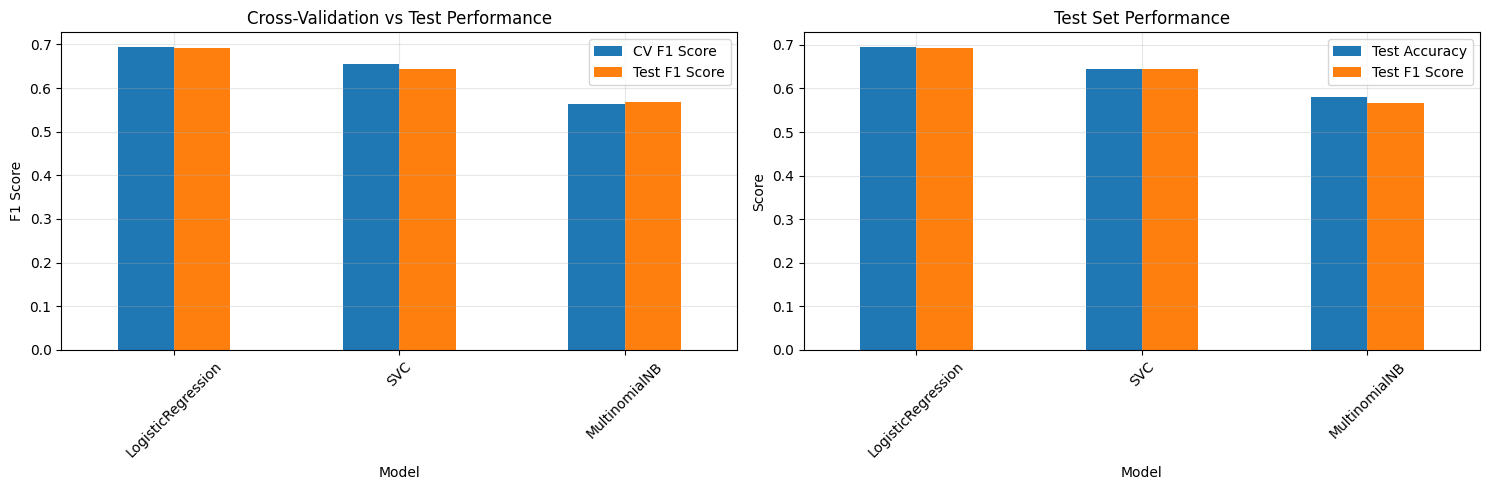

In [13]:
comparison_df = pd.DataFrame(comparison_results)
comparison_df = comparison_df.sort_values('Test F1 Score', ascending=False)

print()
print('=====================')
print("MODEL COMPARISON")
print('=====================')
print(comparison_df.to_string(index=False))

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# CV vs Test scores
comparison_df.set_index('Model')[['CV F1 Score', 'Test F1 Score']].plot(
    kind='bar', ax=axes[0], rot=45
)
axes[0].set_title('Cross-Validation vs Test Performance')
axes[0].set_ylabel('F1 Score')
axes[0].legend(['CV F1 Score', 'Test F1 Score'])
axes[0].grid(True, alpha=0.3)

comparison_df.set_index('Model')[['Test Accuracy', 'Test F1 Score']].plot(
    kind='bar', ax=axes[1], rot=45
)
axes[1].set_title('Test Set Performance')
axes[1].set_ylabel('Score')
axes[1].legend(['Test Accuracy', 'Test F1 Score'])
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

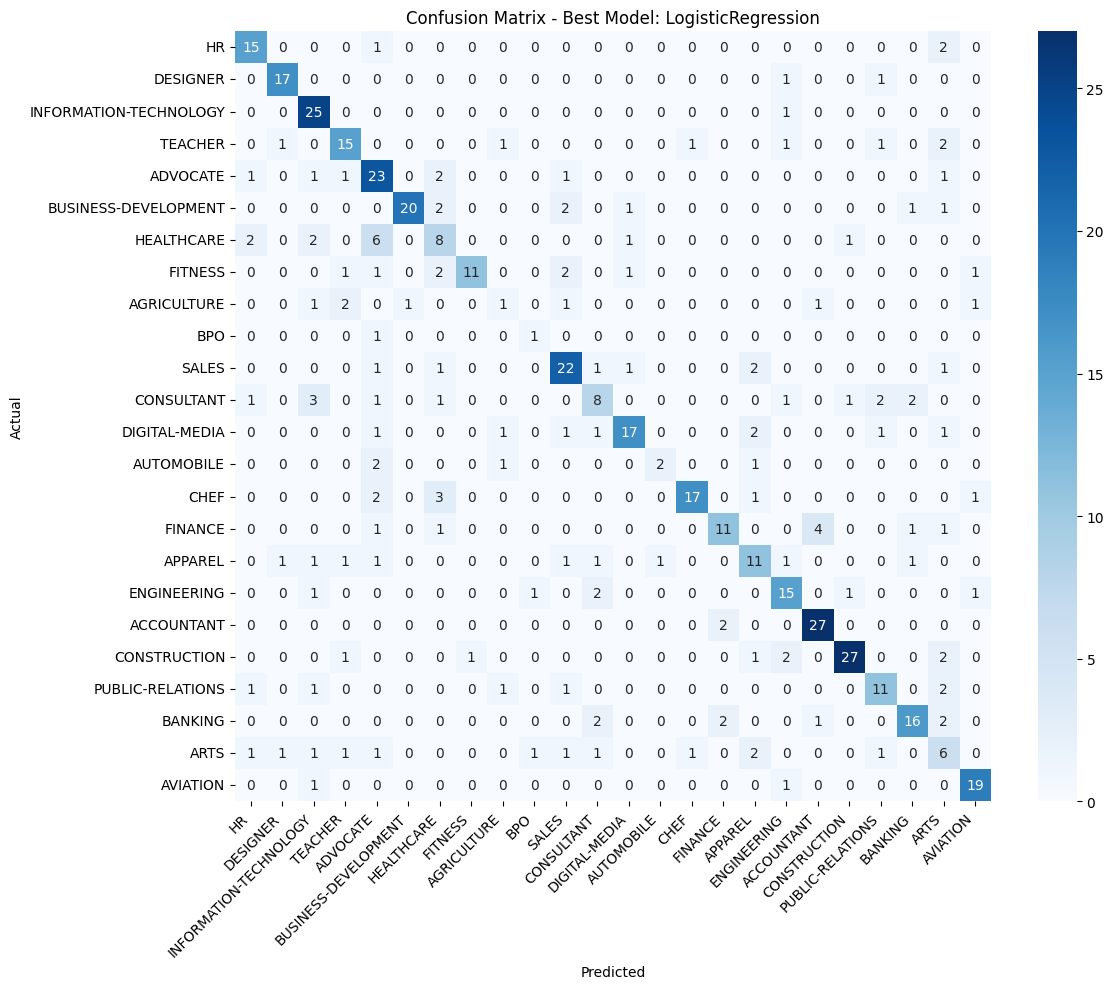

In [14]:
best_model_name = comparison_df.iloc[0]['Model']
best_model = grid_results[best_model_name]['best_estimator']

y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=y.unique())

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=y.unique(),
            yticklabels=y.unique(), cmap='Blues')
plt.title(f"Confusion Matrix - Best Model: {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Save Model for Production Deployment

In [ ]:
# Save the best model and preprocessing function for deployment
joblib.dump(best_model, '../models/best_resume_classifier_model.pkl')

# Save the normalize_document function and stop_words for use in the Streamlit app
import pickle
with open('../models/preprocessing_utils.pkl', 'wb') as f:
    pickle.dump({'normalize_document': normalize_document, 'stop_words': stop_words}, f)

## Launch Streamlit App

In [1]:
# Launch Streamlit app

import subprocess
import webbrowser
import time
from threading import Timer

def open_browser():
    webbrowser.open('http://localhost:8501')

# Open browser after 2 seconds
Timer(2, open_browser).start()

# Run streamlit
!streamlit run ../app.py --server.headless=true




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://192.168.1.239:8501
  External URL: http://99.28.249.98:8501

  For better performance, install the Watchdog module:

  $ xcode-select --install
  $ pip install watchdog
            
^C
  Stopping...
Exception ignored in: <module 'threading' from '/Users/kevinschroeder/.pyenv/versions/3.12.12/lib/python3.12/threading.py'>
Traceback (most recent call last):
  File "/Users/kevinschroeder/.pyenv/versions/3.12.12/lib/python3.12/threading.py", line 1594, in _shutdown
    atexit_call()
  File "/Users/kevinschroeder/.pyenv/versions/3.12.12/lib/python3.12/concurrent/futures/thread.py", line 31, in _python_exit
    t.join()
  File "/Users/kevinschroeder/.pyenv/versions/3.12.12/lib/python3.12/threading.py", line 1149, in join
    self._wait_for_tstate_lock()
  File "/Users/kevinschroeder/.pyenv/versions/3.12.12/lib/python3.12/threading.py", line 1169, in _wait_for_tstate_lock
    if

# Personal Contribution Statement (10pts). Write it in markdown (do not use code block comments)

Summary of tasks and team members' contributions

Proofreading

Allen:
I developed and executed the model training pipeline, including data preprocessing, model selection, and evaluation. I created visualizations to highlight performance across models, using bar plots to communicate differences in cross-validation and test metrics a detailed confusion matrix to analyze its classification behavior on the test set.



Kevin: We split the work up equally and everyone fairly contributed. I contributed by developing a systematic approach to evaluate and optimize multiple machine learning models, including Logistic Regression, Multinomial Naive Bayes, and LinearSVC. I performed in-depth hyperparameter tuning for both the models and the TF-IDF vectorizer to improve performance and identify the best combination of parameters and features based on F1 score. I also explored Streamlit deployment options to enable an interactive, user-friendly, and free-to-use interface for our final model.


Si:

I set up the Jupyter notebook for coding. I performed the first step, preprocessing steps, which include loading resume data, creating corpus, and normalizing corpus. These steps prepared the norm_corpus to use in the upcoming pipeline and model training. I also added the description of main task for this application.
